# Reformatting Ubuntu Dialogue Corpus for Chatbot Model

## Dataset Description

**How to run this notebook**: 
1. Download the data from the [github repository](https://github.com/rkadlec/ubuntu-ranking-dataset-creator)
2. CD to the downloaded directory and run ```./generate.sh -t -l```. I downloaded 1 mill. train samples with p = 1.0. 
3. Change the value of DATA_DIR below to your project path root.

I chose to copy the first 10k lines of data into a "sample" directory so I could quickly play around with the data, and then use the full dataset when done.

Random facts [from paper](https://arxiv.org/abs/1506.08909):
* 2-way (dyadic) conversation, as opposed to multi-participant.


## Load the Data

In [1]:
import numpy as np
import os.path
import pdb
import pandas as pd
from pprint import pprint

#DATA_DIR = '/home/brandon/terabyte/Datasets/ubuntu_dialogue_corpus/'
DATA_DIR = '/home/brandon/ubuntu_dialogue_corpus/sample/'
TRAIN_PATH = DATA_DIR + 'train.csv'
VALID_PATH = DATA_DIR + 'valid.csv'
TEST_PATH = DATA_DIR + 'test.csv'

def get_training():
    """Returns dataframe data from train.csv """
    # First, we need to load the data directly into a dataframe from the train.csv file. 
    df_train = pd.read_csv(TRAIN_PATH)
    # Remove all examples with label = 0. (why would i want to train on false examples?)
    df_train = df_train.loc[df_train['Label'] == 1.0]
    # Don't care about the pandas indices in the df, so remove them.
    df_train = df_train.reset_index(drop=True)
    df_train = df_train[df_train.columns[:2]]
    return df_train

def get_validation():
    """Returns data from valid.csv """
    # First, we need to load the data directly into a dataframe from the train.csv file. 
    df_valid = pd.read_csv(VALID_PATH)
    first_two_cols = df_valid.columns[:2]
    df_valid = df_valid[first_two_cols]
    df_valid.columns = ['Context', 'Utterance']
    return df_valid

df_train = get_training()
df_valid = get_validation()

## Functions for Visualization and Reformatting

In [18]:
# Now get all of the data in a single string and make a 'vocabulary' (unique words). 
import nltk, re, pprint
from nltk import word_tokenize
import pdb

def print_single_turn(turn: str):
    as_list_of_utters = turn.split('__eou__')[:-1]
    for idx_utter, utter in enumerate(as_list_of_utters):
        print("\t>>>", utter)

def print_conversation(df, index=0):
    """Display the ith conversation in nice format."""
    
    # Get the row identified by 'index'. 
    context_entry = df['Context'].values[index]
    target        = df['Utterance'].values[index]
    
    # Split returns a blank last entry, so don't store.
    turns = context_entry.split('__eot__')[:-1]
    print('--------------------- CONTEXT ------------------- ')
    for idx_turn, turn in enumerate(turns):
        print("\nUser {}: ".format(idx_turn % 2))
        print_single_turn(turn)
    print('\n--------------------- RESPONSE ------------------- ')
    print("\nUser {}: ".format(len(turns) % 2))
    print_single_turn(target)
        
def get_user_arrays(df):
    """Returns two arrays of every other turn. 
    Specifically:
        len(returned array) is number of rows in df.  I SURE HOPE NOT!
        each entry is a numpy array. 
        each numpy array contains utterances as entries. 
    """
    userOne = []
    userTwo = []
    contexts = df['Context'].values
    targets  = df['Utterance'].values
    assert(len(contexts) == len(targets))
    
    for i in range(len(contexts)):
        # combined SINGLE CONVERSATION ENTRY of multiple turns each with multiple utterances.
        list_of_turns = contexts[i].split('__eot__')[:-1] + [targets[i]]
        # make sure even number of entries
        if len(list_of_turns) % 2 != 0:
            list_of_turns = list_of_turns[:-1]
        # strip out the __eou__ occurences (leading space bc otherwise would result in two spaces)
        new_list_of_turns = []
        for turn in list_of_turns:
            utter_list = turn.split(" __eou__")
            #if len(utter_list) > 3:
            #   utter_list = utter_list[:3]
            new_list_of_turns.append("".join(utter_list))
        #list_of_turns = [re.sub(' __eou__', '', t) for t in list_of_turns]
        userOneThisConvo = new_list_of_turns[0::2]
        userTwoThisConvo = new_list_of_turns[1::2]
        userOne += userOneThisConvo 
        userTwo += userTwoThisConvo
    assert(len(userOne) == len(userTwo))
    return userOne, userTwo

def save_to_file(fname, arr):
    with open(DATA_DIR+fname,"w") as f:
        for line in arr:
            f.write(line + "\n")

## Training Data

#### At a Glance

In [9]:
df_train.describe()

,Context,Utterance
count,4992,4992
unique,4992,4726
top,"man __eou__ my xserver be still break = [ __eou__ even after upgrad to hoari __eou__ lol __eou__ lol , welcom back dcm __eou__ well __eou__ he have n't be k-line , so i guess he promis to knock it off __eou__ __eot__ you be a retard __eou__ sf.net __eou__ http : //sf.net __eou__ __eot__",thank __eou__
freq,1,56


In [6]:
pd.options.display.max_colwidth = 500
df_train.head(2)

df_train has 4992 rows.


,Context,Utterance
0,"i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there __eou__ __eot__ it would be veri easi to keep a hash db of message-id __eou__ sound good __eou__ __eot__ ok __eou__ perhap we can ship an ad-hoc apt_preferec __eou__ __eot__ version ? __eou__ __eot__ thank __eou__ __eot__ not yet __eou__ it be cover by your insur ? __eou__ __eot__ yes __eou__ but it 's realli no...",basic each xfree86 upload will not forc user to upgrad 100mb of font for noth __eou__ no someth i do in my spare time . __eou__
1,"interest __eou__ grub-instal work with / be ext3 , fail when it be xfs __eou__ i think d-i instal the relev kernel for your machin . i have a p4 and it instal the 386 kernel __eou__ holi crap a lot of stuff get instal by default : ) __eou__ you be instal vim on a box of mine __eou__ ; ) __eou__ __eot__ more like osx than debian ; ) __eou__ we have a select of python modul avail for great justic ( and python develop ) __eou__ __eot__ 2.8 be fix them iirc __eou__ __eot__ pong __eou__ vino will...",that the one __eou__


In [12]:
print_conversation(df_train, 3)

--------------------- CONTEXT ------------------- 

User 0: 
	>>> edd will turn up here soon too , btw 

User 1: 
	>>>  should we renam this chan # gnome-hack ? : ) 
	>>>  around ? 
	>>>  what 's go on about desktop file ? 
	>>>  around ? 
	>>>  direct ? 

User 0: 
	>>>  ross be here 

--------------------- RESPONSE ------------------- 

User 1: 
	>>> you need to go out of the sleepi mode dude 
	>>>  gnomedb should be 1.1.x sinc it 's a gnome part , right ? 


#### Turn-Based DataFrame

In [55]:
#df_merged = pd.DataFrame(df_train['Context'].map(str) + df_train['Utterance'])
userOne, userTwo = get_user_arrays(df_train)
df_turns = pd.DataFrame({'UserOne': userOne, 'UserTwo': userTwo})
df_turns.head(20)

,UserOne,UserTwo
0,"i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there",it would be veri easi to keep a hash db of message-id sound good
1,ok perhap we can ship an ad-hoc apt_preferec,version ?
2,thank,not yet it be cover by your insur ?
3,yes but it 's realli not the right time : / with a chang hous upcom in 3 week,you will be move into your hous soon ? post a messag recent which explain what to do if the autoconfigur doe not do what you expect
4,how urgent be # 896 ?,"not particular urgent , but a polici violat"
5,i agre that we should kill the -novtswitch,ok
6,would you consid a packag split a featur ?,context ?
7,split xfonts* out of xfree86* . one upload for the rest of the life and that 's it,split the sourc packag you mean ?
8,yes . same binari packag .,"i would prefer to avoid it at this stage . this be someth that have go into xsf svn , i assum ?"
9,"interest grub-instal work with / be ext3 , fail when it be xfs i think d-i instal the relev kernel for your machin . i have a p4 and it instal the 386 kernel holi crap a lot of stuff get instal by default : ) you be instal vim on a box of mine ; )",more like osx than debian ; ) we have a select of python modul avail for great justic ( and python develop )


#### Sentence-Based DataFrame

In [54]:
userOne[0]

'i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there '

In [62]:

def get_sentences(userOne, userTwo):
    encoder = []
    decoder = []
    assert(len(userOne) == len(userTwo))
    for i in range(len(userOne)):
        one = nltk.sent_tokenize(userOne[i])
        one = [s for s in one if s != '.']
        two = nltk.sent_tokenize(userTwo[i])
        two = [s for s in two if s != '.']
        combine = one + two
        assert(len(combine) == len(one) + len(two))
        if len(combine) % 2 != 0:
            combine = combine[:-1]
        enc = combine[0::2]
        dec = combine[1::2]
        assert(len(enc) == len(dec))
        encoder.append(enc)
        decoder.append(dec)
    return encoder, decoder
encoder, decoder = get_sentences(userOne, userTwo)
print('done')

done


In [68]:
encoder = [nltk.word_tokenize(s[0]) for s in encoder]
decoder = [nltk.word_tokenize(s[0]) for s in decoder]

In [73]:
max_enc_len = max([len(s) for s in encoder])
max_dec_len = max([len(s) for s in decoder])
print(max_enc_len)
print(max_dec_len)

150
133


#### Analyzing Sentence Lengths

In [75]:
encoder_lengths = [len(s) for s in encoder]
decoder_lengths = [len(s) for s in decoder]
df_lengths = pd.DataFrame({'EncoderSentLength': encoder_lengths, 'DecoderSentLengths': decoder_lengths})
df_lengths.describe()

,DecoderSentLengths,EncoderSentLength
count,11004.00000,11004.000000
mean,11.82679,13.491821
std,10.65755,12.127613
min,1.00000,1.000000
25%,5.00000,6.000000
50%,9.00000,10.000000
75%,15.00000,17.000000
max,133.00000,150.000000


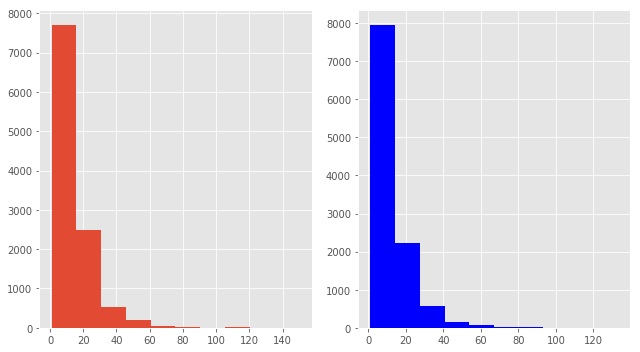

In [89]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 9, 5
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
plt.hist(encoder_lengths)
plt.subplot(1, 2, 2)
plt.hist(decoder_lengths, color='b')
plt.tight_layout()
plt.show()

In [45]:
save_to_file("train_from.txt", userOne)
save_to_file("train_to.txt", userTwo)

### Validation Data

In [46]:
print("df_valid has", len(df_valid), "rows.")
df_valid.head()

df_valid has 19560 rows.


,Context,Utterance
0,Any ideas on how lts will be released ? __eou_...,We are talking 12.04 not 10.04 __eou__
1,how much hdd use ubuntu default install ? __eo...,thats why i ask how much is default install ? ...
2,in my country its nearly the 27th __eou__ when...,thanx __eou__
3,it 's not out __eou__ __eot__ they probabaly a...,waiting for many things to be setup __eou__ fi...
4,are the ext4 drivers stable ? __eou__ __eot__ ...,you sound like it 's updating to skynet . ; ) ...


In [47]:
userOne, userTwo = get_user_arrays(df_valid)
save_to_file("valid_from.txt", userOne)
save_to_file("valid_to.txt", userTwo)

# Visualization

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

lengths = np.array([len(t.split(" ")) for t in userOne])

max_ind =  lengths.argmax()
print(max(lengths), "at", max_ind)
print("Sentence:\n", userOne[max_ind])

303 at 796223
Sentence:
 I recently got frustrated with my laptop cause it was frozen , so being the impatient person I am , I manually held the power button down and shut it off . Well , next time I try to turn on my laptop , it gives me ( I had to paraphrase it ) `` Unable to insert capability.ko '' and it remains that way . This is on the latest kernel from the update manager . I try another kernel and it gives me `` Invalid '' several times before stopping . I tried recovery mode too . It seems I recently got frustrated with my laptop cause it was frozen , so being the impatient person I am , I manually held the power button down and shut it off . Well , next time I try to turn on my laptop , it gives me ( I had to paraphrase it ) `` Unable to insert capability.ko '' and it remains that way . This is on the latest kernel from the update manager . I try another kernel and it gives me `` Invalid '' several times before stopping . I tried recovery mode too . It seems I recently got fr

(array([  1.57268900e+06,   4.56976000e+05,   9.65080000e+04,
          2.23840000e+04,   5.33500000e+03,   1.42000000e+03,
          4.71000000e+02,   1.63000000e+02,   5.80000000e+01,
          3.00000000e+01]),
 array([   1. ,   26.5,   52. ,   77.5,  103. ,  128.5,  154. ,  179.5,
         205. ,  230.5,  256. ]),
 <a list of 10 Patch objects>)

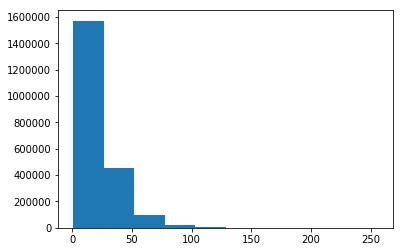

In [144]:
import matplotlib.pyplot as plt
plt.hist(sorted(lengths)[:-20])

In [145]:
n_under_20 = sum([1 if l < 100 else 0 for l in lengths])
print(n_under_20, "out of", len(lengths), "({}\%)".format(float(n_under_20)/len(lengths)))

2147224 out of 2156054 (0.995904555266241\%)


In [110]:
df_lengths = pd.DataFrame(lengths)

In [111]:
df_lengths.describe()

,0
count,391.000000
mean,11.299233
std,7.285741
min,1.000000
25%,6.000000
50%,10.000000
75%,15.500000
max,46.000000


## Relationship between Accuracy, Loss, and Others

$$
\text{Loss} = - \frac{1}{N} \sum_{i = 1}^{N} \ln\left(p_{target_i}\right)
$$

Loss for uniformly random guessing is 10.5966347331


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


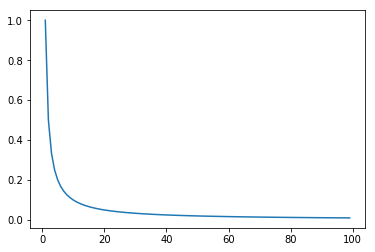

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Number of gradient descent steps, each over a batch_size amount of data.
vocab_size = 40000

# Uniform chance of guessing any word. 
loss_random_guess = np.log(float(vocab_size))
print("Loss for uniformly random guessing is", loss_random_guess)

sent_length = [5, 10, 25]
# Outputs correct target x percent of the time. 
pred_accuracy = np.arange(100)

plt.plot(pred_accuracy, [1./p for p in pred_accuracy])

99


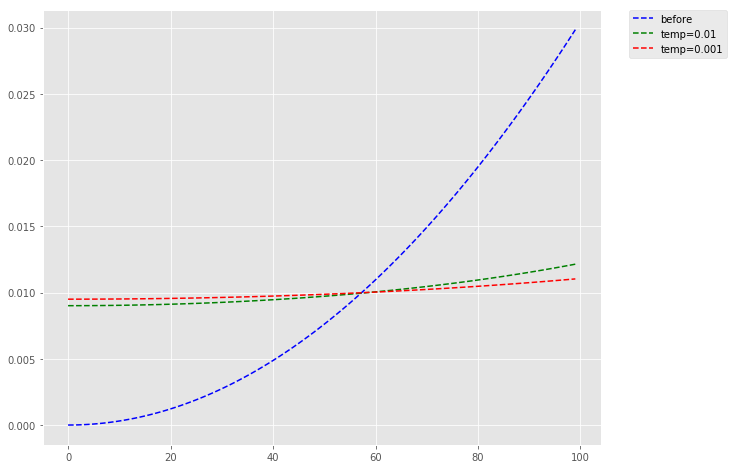

In [27]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 8
def _sample(logits, t):
    res = logits / t
    res = np.exp(res) / np.sum(np.exp(res))
    return res

N = 100
x = np.arange(N)
before = np.array([1.0+i**2 for i in range(N)])
before /= before.sum()

plt.plot(x, before, 'b--', label='before')

after = _sample(before, 0.1)
plt.plot(x, after, 'g--', label='temp=0.01')

after = _sample(before, 0.2)
print(after.argmax())
plt.plot(x, after, 'r--', label='temp=0.001')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [5]:
np.info(plt.plot)

 plot(*args, **kwargs)

Plot lines and/or markers to the
:class:`~matplotlib.axes.Axes`.  *args* is a variable length
argument, allowing for multiple *x*, *y* pairs with an
optional format string.  For example, each of the following is
legal::

    plot(x, y)        # plot x and y using default line style and color
    plot(x, y, 'bo')  # plot x and y using blue circle markers
    plot(y)           # plot y using x as index array 0..N-1
    plot(y, 'r+')     # ditto, but with red plusses

If *x* and/or *y* is 2-dimensional, then the corresponding columns
will be plotted.

If used with labeled data, make sure that the color spec is not
included as an element in data, as otherwise the last case
``plot("v","r", data={"v":..., "r":...)``
can be interpreted as the first case which would do ``plot(v, r)``
using the default line style and color.

If not used with labeled data (i.e., without a data argument),
an arbitrary number of *x*, *y*, *fmt* groups can be specified, as in::

    a.plot(x